In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

## Travel time prediction

In [ ]:
data = pd.read_csv('../dataPreprocessing/data/data.csv', low_memory=False)

In [ ]:
data.info()

In [ ]:
#split data
data.datetime = data.datetime.apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H'))
data = data.sort_values(['datetime','sequence_id'])

In [ ]:
data.shape

In [ ]:
#fillna 
data.fillna(-1, inplace=True)

In [ ]:
#train test split
test_seq_count = round(data.sequence_id.nunique() * 0.3)
test_sequences = pd.Series(data.sequence_id.unique()).tail(test_seq_count).values

In [ ]:
train = data[~data.sequence_id.isin(test_sequences)]
test  = data[data.sequence_id.isin(test_sequences)]

In [12]:
X_train = data[~data.sequence_id.isin(test_sequences)].drop(['datetime_diff', 'outlier', 'datetime'], axis=1)
y_train  = data[~data.sequence_id.isin(test_sequences)].datetime_diff

X_test  = data[data.sequence_id.isin(test_sequences)].drop(['datetime_diff', 'outlier', 'datetime'], axis=1)
y_test  = data[data.sequence_id.isin(test_sequences)].datetime_diff

In [ ]:
plt.figure(figsize=(15,5))
X_train.groupby('line_label').sequence_id.count().plot(kind = 'bar')
plt.plot(np.arange(31), np.ones(31)*1000, 'r--')
plt.title('train data')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
X_test.groupby('line_label').sequence_id.count().plot(kind = 'bar')
plt.plot(np.arange(31), np.ones(31)*1000, 'r--')
plt.title('test data')
plt.show()

In [37]:
#scale data
#min max scaler
from pickle import dump
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

scaler = MinMaxScaler()
encoder = LabelEncoder()

encoder.fit(data[['line_label']])
X_train.line_label = encoder.transform(X_train.line_label)
X_test.line_label  = encoder.transform(X_test.line_label)

C:\Users\Aziz\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [38]:
X_train = X_train.drop('sequence_id', axis=1).values
X_test = X_test.drop('sequence_id', axis=1).values

In [39]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [40]:
X_train.shape

(919349, 19)

In [41]:
X_test.shape

(717310, 19)

In [42]:
y_train = y_train.values.reshape(-1,1)
y_test  = y_test.values.reshape(-1,1)

In [43]:
X_train = X_train.reshape(-1,1,19)
X_test = X_test.reshape(-1,1,19)

In [44]:
X_train.shape

(919349, 1, 19)

In [45]:
X_test.shape

(717310, 1, 19)

In [46]:
y_train.shape

(919349, 1)

In [47]:
y_test.shape

(717310, 1)

## LSTM one to one

In [9]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, RNN, GRU, LSTM, Dropout
from tensorflow.keras.losses import MAE, MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

In [10]:
model = Sequential()
model.add(LSTM(units=128,  activation='relu', input_shape=(1,19),return_sequences = True))
model.add(LSTM(units=128,  activation='relu', input_shape=(1,19),return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            75776     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

In [11]:
optimizer = Adam(lr=0.001)
loss = MeanSquaredError()
metric = RootMeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [57]:
model.fit(X_train, y_train, epochs=10, batch_size=124, shuffle=False,
         callbacks=[EarlyStopping(restore_best_weights=True, patience=3, monitor='root_mean_squared_error')])

Epoch 1/10
7415/7415 [==============================] - 47s 6ms/step - loss: 10816.6238 - root_mean_squared_error: 103.2917
Epoch 2/10
7415/7415 [==============================] - 45s 6ms/step - loss: 7702.2246 - root_mean_squared_error: 87.6832
Epoch 3/10
7415/7415 [==============================] - 44s 6ms/step - loss: 7225.0720 - root_mean_squared_error: 84.8554
Epoch 4/10
7415/7415 [==============================] - 44s 6ms/step - loss: 6189.7251 - root_mean_squared_error: 78.6193
Epoch 5/10
7415/7415 [==============================] - 45s 6ms/step - loss: 5854.1906 - root_mean_squared_error: 76.4765
Epoch 6/10
7415/7415 [==============================] - 46s 6ms/step - loss: 5619.8770 - root_mean_squared_error: 74.9404
Epoch 7/10
7415/7415 [==============================] - 45s 6ms/step - loss: 5480.0074 - root_mean_squared_error: 74.0053
Epoch 8/10
7415/7415 [==============================] - 45s 6ms/step - loss: 5367.7966 - root_mean_squared_error: 73.2435
Epoch 9/10
7415/7415 [

In [58]:
y_pred = model.predict(X_test)
#y_pred = y_pred.reshape(-1,)
#y_test = y_test.datetime_diff.values

In [36]:
#y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1,1))
#y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1,1))

In [59]:
from sklearn.metrics import r2_score,mean_squared_error

print('test rsquared : ', r2_score(y_test,y_pred))
print('test rmse     : ', np.sqrt(mean_squared_error(y_test,y_pred)))

test rsquared :  0.5174144872209843
test rmse     :  75.40403326548456


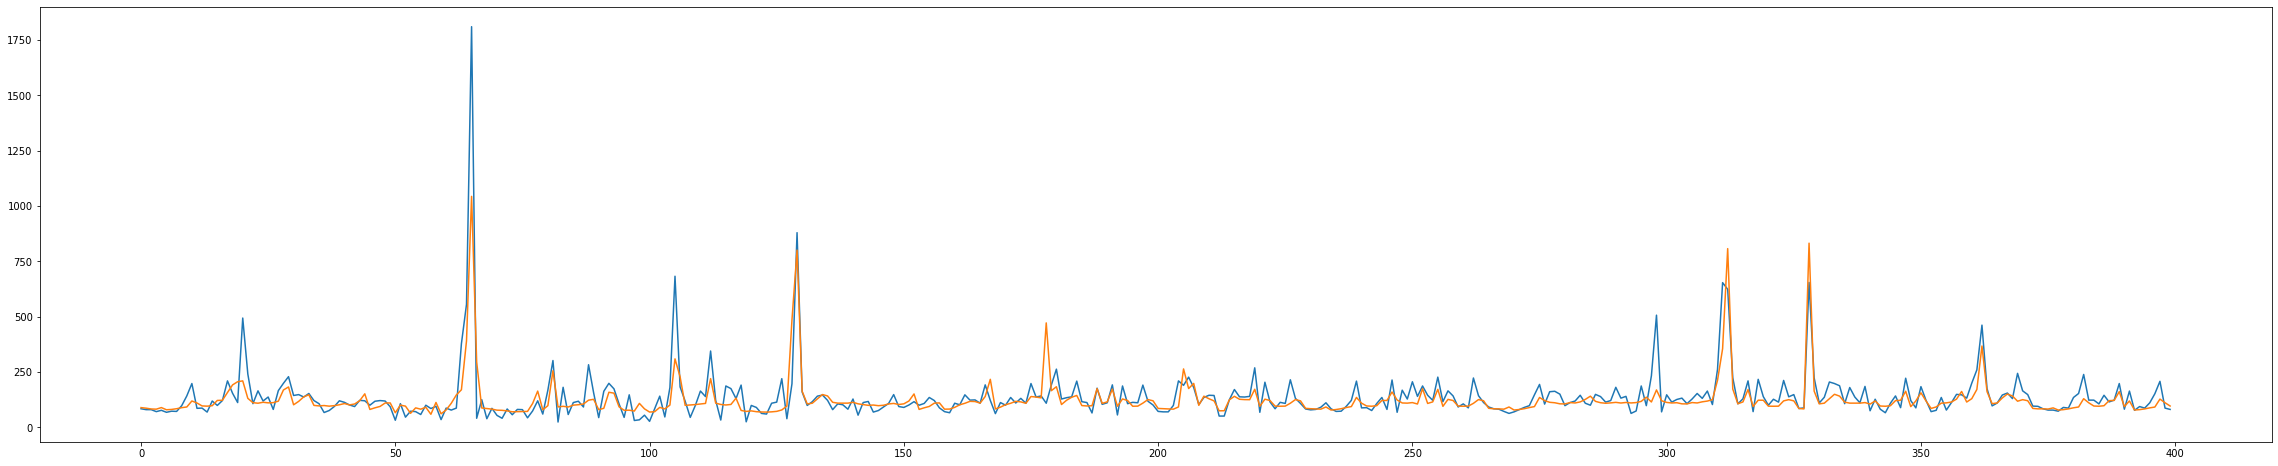

In [60]:
plt.figure(figsize=(40,8))
plt.plot(np.arange(y_test[10000:10400].shape[0]), y_test[10000:10400])
plt.plot(np.arange(y_test[10000:10400].shape[0]), y_pred[10000:10400])

In [62]:
#export model
model.save_weights('checkpoint/one_to_one.cpkt')

## LSTM Many To One : 3 time step window

In [ ]:
train.columns

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

encoder = LabelEncoder()

encoder.fit(data[['line_label']])
train.line_label = encoder.transform(train.line_label)
test.line_label  = encoder.transform(test.line_label)

In [ ]:
train.drop(['outlier','datetime'], axis=1, inplace=True)
test.drop(['outlier','datetime'], axis=1, inplace=True)

In [ ]:
scaler = MinMaxScaler()
scaler_notarget = MinMaxScaler()

scaler.fit(train.drop(['sequence_id'], axis=1) )
scaler_notarget.fit(train.drop(['sequence_id','datetime_diff'], axis=1) );

In [ ]:
train_input_X1 = scaler.transform(train.groupby('sequence_id',dropna=False).shift(2).fillna(-1))
train_input_X2 = scaler.transform(train.groupby('sequence_id',dropna=False).shift(1).fillna(-1))
train_input_X3 = scaler_notarget.transform(train.drop(['sequence_id', 'datetime_diff'], axis=1).fillna(-1))

In [ ]:
test_input_X1 = scaler.transform(test.groupby('sequence_id',dropna=False).shift(2).fillna(-1))
test_input_X2 = scaler.transform(test.groupby('sequence_id',dropna=False).shift(1).fillna(-1))
test_input_X3 = scaler_notarget.transform(test.drop(['sequence_id', 'datetime_diff'], axis=1).fillna(-1))

In [ ]:
y_train = train[['datetime_diff']].values
y_train.shape

In [ ]:
y_test = test[['datetime_diff']].values
y_test.shape

In [ ]:
#one time step
train_input_X1 = train_input_X1.reshape(-1,1,20)
train_input_X1.shape

In [ ]:
#two time steps
train_input_X2 = train_input_X2.reshape(-1,1,20)
train_input_X2.shape

In [ ]:
#three time steps
train_input_X3 = train_input_X3.reshape(-1,1,19)
train_input_X3.shape

In [ ]:
#one time step
test_input_X1 = test_input_X1.reshape(-1,1,20)
test_input_X1.shape

In [ ]:
test_input_X2 = test_input_X2.reshape(-1,1,20)
test_input_X2.shape

In [ ]:
test_input_X3 = test_input_X3.reshape(-1,1,19)
test_input_X3.shape

In [ ]:
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, RNN, GRU, LSTM, Dropout, concatenate, BatchNormalization, Multiply
from tensorflow.keras.losses import MAE, MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
#model architecture keras API

#three time step inputs
time_step1 = Input(shape = (1,20))
time_step2 = Input(shape = (1,20))
time_step3 = Input(shape = (1,19))

#hidden standraizers layers
dense_ts1 = Dense(19, activation = 'relu')(time_step1)
dense_ts2 = Dense(19, activation = 'relu')(time_step2)
dense_ts3 = Dense(19, activation = 'relu')(time_step3)

#concatenate time step features in order
x  = concatenate([dense_ts1,dense_ts2,dense_ts3], axis = 1)

#Lstm / Gru / Rnn
x = LSTM(units = 124, activation='tanh' , input_shape = (-1, 3, 19), return_sequences=False)(x)

#Dense layers
x = Dense(124, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
out = Dense(1, activation='relu')(x)

In [ ]:
model = Model([time_step1, time_step2,time_step3], out)
model.summary()

In [ ]:
optimizer = Adam(lr=0.001)
loss = MeanSquaredError()
metric = RootMeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [ ]:
#tensorflow data pipeline 
dataset = Dataset.from_tensor_slices(((train_input_X1, train_input_X2, train_input_X3), y_train))
dataset = dataset.batch(64)
train_data = dataset.prefetch(tf.data.experimental.AUTOTUNE)

dataset = Dataset.from_tensor_slices(((test_input_X1, test_input_X2, test_input_X3), y_test))
dataset = dataset.batch(64)
test_data = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [72]:
model.fit(train_data, validation_data = test_data, epochs=20 , shuffle=False , workers=8, use_multiprocessing=True,
          callbacks = EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 3, restore_best_weights=True)  )

Epoch 1/20
3592/3592 [==============================] - 61s 13ms/step - loss: 10967.4785 - root_mean_squared_error: 104.2455 - val_loss: 9195.5635 - val_root_mean_squared_error: 95.8935
Epoch 2/20
3592/3592 [==============================] - 46s 13ms/step - loss: 8315.7509 - root_mean_squared_error: 91.1000 - val_loss: 8316.3818 - val_root_mean_squared_error: 91.1942
Epoch 3/20
3592/3592 [==============================] - 59s 16ms/step - loss: 7314.4773 - root_mean_squared_error: 85.4539 - val_loss: 7227.8276 - val_root_mean_squared_error: 85.0166
Epoch 4/20
3592/3592 [==============================] - 57s 16ms/step - loss: 6521.9650 - root_mean_squared_error: 80.7154 - val_loss: 6647.6123 - val_root_mean_squared_error: 81.5329
Epoch 5/20
3592/3592 [==============================] - 57s 16ms/step - loss: 5866.5994 - root_mean_squared_error: 76.5632 - val_loss: 6434.5610 - val_root_mean_squared_error: 80.2157
Epoch 6/20
3592/3592 [==============================] - 59s 16ms/step - loss: 

In [79]:
loss, rmse = model.evaluate(test_data)
print('test loss : {:.2f}    test rmse : {:.2f} '.format(loss, rmse))

11208/11208 [==============================] - 57s 5ms/step - loss: 4138.2564 - root_mean_squared_error: 64.3190
test loss : 4355.77    test rmse : 66.00 


In [80]:
y_pred = model.predict(test_data)

In [82]:
from sklearn.metrics import r2_score,mean_squared_error

print('test rsquared : ', r2_score(y_test,y_pred))

test rsquared :  0.6302992527537107


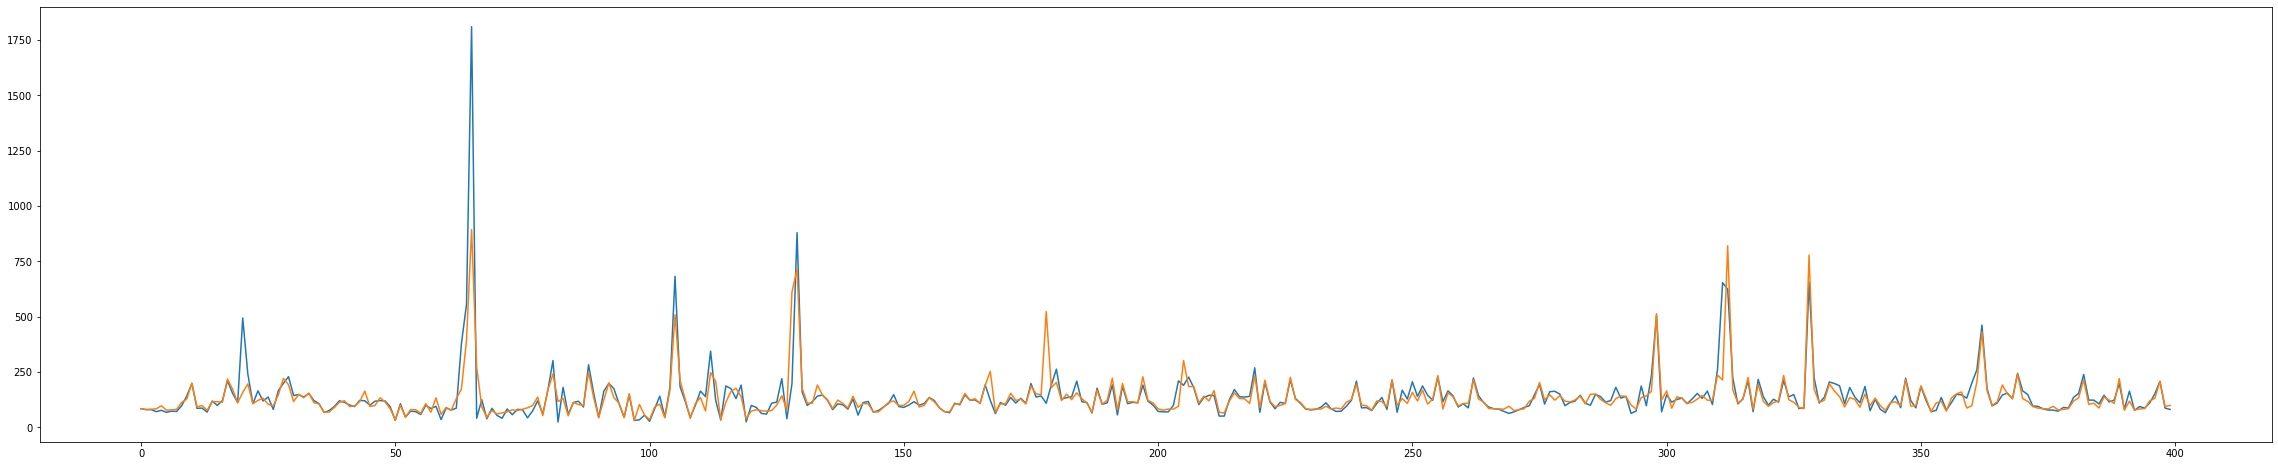

In [83]:
plt.figure(figsize=(40,8))
plt.plot(np.arange(y_test[10000:10400].shape[0]), y_test[10000:10400])
plt.plot(np.arange(y_test[10000:10400].shape[0]), y_pred[10000:10400])

In [49]:
#export model
model.save_weights('./checkpoint/Many_to_one.cpkt')

### Confidence and prediction Intervals : 

In [ ]:
import scipy

In [ ]:
model.load_weights('./checkpoint/Many_to_one.cpkt');

In [ ]:
y_pred = model.predict(test_data)

In [ ]:
epsilon = (y_test - y_pred)

In [ ]:
epsilon = epsilon.reshape(-1)
epsilon.shape

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (20,5) )
axs[0].set_title('Error distribution')
axs[0].hist(epsilon, bins=300)
axs[1].set_title('Error vs prediction')
axs[1].plot(y_pred, epsilon, '.')
axs[1].plot(y_pred, np.zeros(y_pred.shape[0]), 'r-')

plt.show()

In [ ]:
np.mean(epsilon)

In [ ]:
scipy.stats.shapiro(epsilon)

In [ ]:
scipy.stats.kstest(epsilon, 'norm')